In [591]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib.pylab as pylab
import pickle
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

params = {'legend.fontsize': 10,
          'figure.figsize': (5.728, 3.54),
          'figure.dpi': 100,
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}

pylab.rcParams.update(params)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#FFDB58', '#a65628']
markers = ['o', "^", "v", "*", "+", "x", "s", "p"]
linestyles = ['-', '--', '-.', ':', '-', '--', ':', '-.']

In [592]:
class PositionNeuron:
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(PositionNeuron, self).__init__()
        self.E_L = parameters['E_L']
        self.V_T = parameters['V_T']
        self.tau = parameters['tau']
        self.tau_W = parameters['tau_W']
        self.tau_epsp = parameters['tau_epsp']
        self.b = parameters['b']
        self.V_R = parameters['V_R']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.E_L),
                                          w=np.zeros((self.n, self.N_input)),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
        V = self.state.V
        w = self.state.w
        I = self.state.I

        w += input * self.b
        V += self.dt * (np.sum(I, axis=1) - V + self.V_R) / self.tau
        I += self.dt * (w - I) / self.tau_epsp
        w += -self.dt * w / self.tau_W

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [593]:
def get_firing_rate(spike_train, dt, t=0.5, sigma=3, nan_bool=True):
    n = int(t / dt)

    firing_rate = np.convolve(spike_train.astype(int), np.ones(n), mode='same') / t
    firing_rate = gaussian_filter1d(firing_rate, sigma=sigma)

    if nan_bool:
        firing_rate[firing_rate < 0.000001] = np.nan

    return firing_rate

In [594]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = pickle.load(file) 
    
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 

N_SIMULATIONS = 1
N_HAIRS = 50    
N_ANGLES = 18
T_TOTAL = 5
dt = 0.001

N_STEPS = int(T_TOTAL/dt)
time = np.linspace(0, T_TOTAL, num=N_STEPS)

position_parameters_uni = {'E_L': -70e-3, 'V_T': -50e-3, 'tau': 25e-3, 'tau_W': 3e-3, 'tau_epsp': 6e-3, 'b': 8e-3,
                           'V_R': -70e-3, 'n': N_ANGLES, 'N_input': N_HAIRS, 'dt': dt, 'refrac': 0}

position_parameters_bi = {'E_L': -70e-3, 'V_T': -50e-3, 'tau': 25e-3, 'tau_W': 3e-3, 'tau_epsp': 6e-3, 'b': 16e-3,
                          'V_R': -70e-3, 'n': 2 * N_ANGLES, 'N_input': N_HAIRS // 2, 'dt': dt, 'refrac': 0}

position_neuron_uni = PositionNeuron(position_parameters_uni)
position_neuron_uni.initialize_state()
position_neuron_bi = PositionNeuron(position_parameters_bi)
position_neuron_bi.initialize_state()

spike_position_uni = np.empty((N_STEPS, position_parameters_uni['n'], N_SIMULATIONS))
spike_position_bi = np.empty((N_STEPS, position_parameters_bi['n'], N_SIMULATIONS))

In [595]:
for k in tqdm(range(N_SIMULATIONS), desc='Network progress'):        
    for i in range(N_STEPS):
        reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters['n'], (N_HAIRS)))

        _, spike_position_uni[i, :, k] = position_neuron_uni.forward(reshaped_spikes[:18, :])
        _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, N_HAIRS // 2:])
        
with open('data/spike_position', 'wb') as file:
        pickle.dump(spike_position_bi, file)

 ... (more hidden) ...


[168.42758992 169.09261188 170.35059172 ... 228.74783249 227.05546638
 226.16000727]


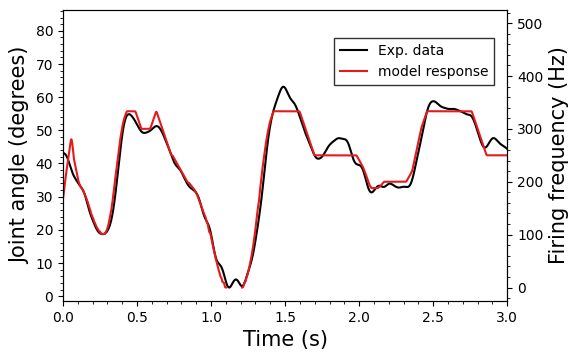

In [596]:
joint_angles = joint_angles_nostep[0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


firing_rate = get_firing_rate(spike_position_uni[:, 1, 0], dt, t=0.1)
print(firing_rate)
ax2.plot(time, firing_rate, color=colors[0], linestyle=linestyles[0], label='model response')

ax1.plot(time, joint_angles[:, 0], color='black', label='Exp. data')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (degrees)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Firing frequency (Hz)")

fig.tight_layout(pad=0.5)
fig.savefig('Images/position_neurons/uni_position_din_.png')
fig.savefig('Images/position_neurons/uni_position_din_.pdf')

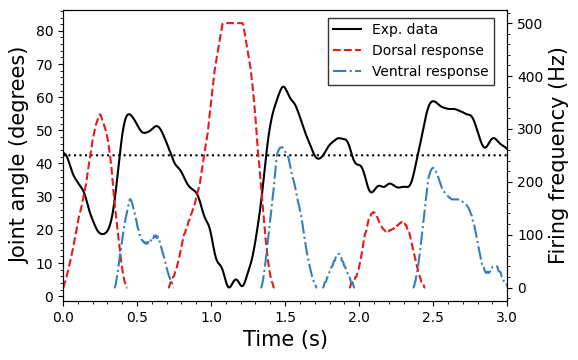

In [597]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

handles = ['Dorsal response', 'Ventral response']

for i in range(2):
    firing_rate = get_firing_rate(spike_position_bi[:, i, 0], dt, t=0.1)
    ax2.plot(time, firing_rate, color=colors[i], linestyle=linestyles[i+1], label = handles[i])


ax1.plot(time, joint_angles[:, 0], color='black', label='Exp. data')
ax1.plot(time, np.full(len(time), np.max(joint_angles[:, 0]) / 2 + np.min(joint_angles[:, 0]) / 2), linestyle='dotted',
         color='black')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (degrees)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Firing frequency (Hz)")

fig.tight_layout(pad=0.5)
fig.savefig('Images/position_neurons/bi_position_din_.png')
fig.savefig('Images/position_neurons/bi_position_din_.pdf')